# 词汇的星空——词向量（Word Vector）技术

在这节课中，我们学习了如何通过人工神经网络得到单词的向量表达。

首先，我们构建了一个简单的NGram语言模型，根据N个历史词汇预测下一个单词，从而得到每一个单词的向量表示。我们用小说《三体》为例，展示了我们的词向量嵌入效果。

其次，我们学习了如何使用成熟的Google开发的Word2Vec包来进行大规模语料的词向量训练，以及如何加载已经训练好的词向量，从而利用这些词向量来做一些简单的运算和测试。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [1]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载‘结巴’中文分词软件包

import jieba

#加载正则表达式处理的包
import re

%matplotlib inline

## 一、NGram 词向量模型

NGram词向量模型的原理是利用一个人工神经网络来根据前N个单词来预测下一个单词，从而得到每个单词的词向量

### 1. 文本预处理

我们以刘慈欣著名的科幻小说《三体》为例，来展示利用NGram模型训练词向量的方法

预处理分为两个步骤：

1、读取文件

2、分词

3、将语料划分为N＋1元组，准备好训练用数据

在这里，我们并没有去除标点符号，一是为了编程简洁，而是考虑到分词会自动将标点符号当作一个单词处理，因此不需要额外考虑。

#### 1). 读入原始文件，筛掉所有标点符号

In [2]:
#读入原始文件

#f = open("../input/三体.txt", 'r', encoding='utf-8')
# 若想加快运行速度，使用下面的语句（选用了三体的其中一章）：
f = open("../input/wordvector/3body.txt", 'r', encoding='utf-8') 
text = str(f.read())
f.close()

text

'八万五千三体时（约8.6个地球年）后。\n\n元首下令召开三体世界全体执政官紧急会议，这很不寻常，一定有什么重大的事件发生。\n\n两万三体时前，三体舰队启航了，它们只知道目标的大致方向，却不知道它的距离。也许，目标处于千万光时之外，甚至在银河系的另一端，面时着前方茫茫的星海，这是一次希望渺茫的远征。\n\n执政官会议在巨摆纪念碑下举行。（汪森在阅读这一段信息时，不由联想到《三体》游戏中的联合国大会，事实上，巨摆纪念碑是游戏中少数在三体世界中真实存在的事物之一。）\n\n元首选定这个会址，令大多数与会者迷惑不解。乱纪元还没有结束，天边刚刚升起了一轮很小的太阳，随时都可能落下，天气异常寒冷，以至于与会者不得不穿上全封闭的电热服。巨大的金属摆气势磅礴地摆动着，冲击着寒冷的空气，天边的小太阳把它的影子长长地投射到大地上，像一个顶天立地的巨人在行走。众目睽睽之下，元首走上巨摆的基座，扳动了一个红色的开关，转身对执政官们说：\n\n“我刚刚关闭了巨摆的动力电源，它将在空气阻力下慢慢地停下来。”\n\n“元首，为什么这样？”一位执政官问。\n\n“我们都清楚巨摆的历史涵义，它是用来对上帝进行催眠的。现在我们知道，上帝醒着对三体文明更有利，它开始保佑我们了。”\n\n众人沉默了，思索着元首这话的含义。在巨摆摆动了三次之后，有人问：“地球文明回电了？”\n\n元首点点头，“是的，半个三体时前我得到的报告，是回答那条警告信息的。”\n\n“这么快？！现在距警告信息发出仅八万多时，这就是说，这就是说……”\n\n“这就是说，地球文明距我们仅四万光时。”\n\n“那不就是距离我们最近的那颗恒星吗？！”\n\n“是的，所以我说：上帝在保佑三体文明。”狂喜在会场上蔓延开来，但又不能充分表现，像被压抑的火山。元首知道，让这种脆弱的情绪爆发出来是有害的，于是，他立刻对“火山”泼了盆冷水：“我已经命令三体舰队航向这颗恒星，但事情并不如你们想象的那样乐观，照目前的情况看，舰队是在航向自己的坟墓。”\n\n元首这话使执政官们立刻冷静下来。\n\n“有人明白我的意思吗？”元首问。\n\n“我明白。”科学执政官说，“我们都仔细研究过第一批收到的地球信息，其中最值得注意的是他们的文明史。请看以下事实：人类从狩猎时代到农业时代，用了十几万地球年时间；从农业时代到工业时代用了几千地球年；而由工业时代到原子时代

#### 2)、分词，并去掉标点符号

In [3]:
# 分词
temp = jieba.lcut(text)
print(len(temp))
words = []
for i in temp:
    #过滤掉所有的标点符号
    i = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", i)
    if len(i) > 0:
        words.append(i)
print(len(words))
words

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.332 seconds.
Prefix dict has been built successfully.


9501
7593


['八万五千',
 '三体',
 '时',
 '约',
 '86',
 '个',
 '地球',
 '年',
 '后',
 '元首',
 '下令',
 '召开',
 '三体',
 '世界',
 '全体',
 '执政官',
 '紧急会议',
 '这',
 '很',
 '不',
 '寻常',
 '一定',
 '有',
 '什么',
 '重大',
 '的',
 '事件',
 '发生',
 '两万',
 '三体',
 '时前',
 '三体',
 '舰队',
 '启航',
 '了',
 '它们',
 '只',
 '知道',
 '目标',
 '的',
 '大致',
 '方向',
 '却',
 '不',
 '知道',
 '它',
 '的',
 '距离',
 '也许',
 '目标',
 '处于',
 '千万',
 '光时',
 '之外',
 '甚至',
 '在',
 '银河系',
 '的',
 '另一端',
 '面时',
 '着',
 '前方',
 '茫茫',
 '的',
 '星海',
 '这是',
 '一次',
 '希望',
 '渺茫',
 '的',
 '远征',
 '执政官',
 '会议',
 '在',
 '巨摆',
 '纪念碑',
 '下',
 '举行',
 '汪森',
 '在',
 '阅读',
 '这',
 '一段',
 '信息',
 '时',
 '不由',
 '联想',
 '到',
 '三体',
 '游戏',
 '中',
 '的',
 '联合国大会',
 '事实上',
 '巨摆',
 '纪念碑',
 '是',
 '游戏',
 '中',
 '少数',
 '在',
 '三体',
 '世界',
 '中',
 '真实',
 '存在',
 '的',
 '事物',
 '之一',
 '元首',
 '选定',
 '这个',
 '会址',
 '令',
 '大多数',
 '与会者',
 '迷惑不解',
 '乱',
 '纪元',
 '还',
 '没有',
 '结束',
 '天边',
 '刚刚',
 '升起',
 '了',
 '一轮',
 '很小',
 '的',
 '太阳',
 '随时',
 '都',
 '可能',
 '落下',
 '天气',
 '异常',
 '寒冷',
 '以至于',
 '与会者',
 '不得不',
 '穿',
 '上',
 '全封闭',
 '的',
 '电热',
 '服',
 

#### 3)、构建N+1元组作为训练数据对

In [4]:
# 构建三元组列表.  每一个元素为： ([ i-2位置的词, i-1位置的词 ], 下一个词)
# 我们选择的Ngram中的N，即窗口大小为2
trigrams = [([words[i], words[i + 1]], words[i + 2]) for i in range(len(words) - 2)]
# 打印出前三个元素看看
print(trigrams[:3])

[(['八万五千', '三体'], '时'), (['三体', '时'], '约'), (['时', '约'], '86')]


#### 4). 将每个单词进行编码，构造词典

In [5]:
# 得到词汇表
vocab = set(words)
print(len(vocab))
# 两个字典，一个根据单词索引其编号，一个根据编号索引单词
#word_to_idx中的值包含两部分，一部分为id，另一部分为单词出现的次数
#word_to_idx中的每一个元素形如：{w:[id, count]}，其中w为一个词，id为该词的编号，count为该单词在words全文中出现的次数
word_to_idx = {} 
idx_to_word = {}
ids = 0

#对全文循环，构建这两个字典
for w in words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

1999


In [6]:
word_to_idx

{'八万五千': [0, 1],
 '三体': [1, 71],
 '时': [2, 26],
 '约': [3, 3],
 '86': [4, 1],
 '个': [5, 7],
 '地球': [6, 71],
 '年': [7, 5],
 '后': [8, 32],
 '元首': [9, 61],
 '下令': [10, 1],
 '召开': [11, 2],
 '世界': [12, 44],
 '全体': [13, 3],
 '执政官': [14, 56],
 '紧急会议': [15, 1],
 '这': [16, 41],
 '很': [17, 18],
 '不': [18, 28],
 '寻常': [19, 1],
 '一定': [20, 4],
 '有': [21, 31],
 '什么': [22, 13],
 '重大': [23, 1],
 '的': [24, 659],
 '事件': [25, 1],
 '发生': [26, 10],
 '两万': [27, 1],
 '时前': [28, 3],
 '舰队': [29, 12],
 '启航': [30, 2],
 '了': [31, 143],
 '它们': [32, 32],
 '只': [33, 4],
 '知道': [34, 12],
 '目标': [35, 8],
 '大致': [36, 1],
 '方向': [37, 5],
 '却': [38, 4],
 '它': [39, 49],
 '距离': [40, 4],
 '也许': [41, 3],
 '处于': [42, 7],
 '千万': [43, 1],
 '光时': [44, 3],
 '之外': [45, 2],
 '甚至': [46, 5],
 '在': [47, 149],
 '银河系': [48, 2],
 '另一端': [49, 1],
 '面时': [50, 1],
 '着': [51, 28],
 '前方': [52, 1],
 '茫茫': [53, 1],
 '星海': [54, 1],
 '这是': [55, 11],
 '一次': [56, 8],
 '希望': [57, 1],
 '渺茫': [58, 1],
 '远征': [59, 2],
 '会议': [60, 3],
 '巨摆': [61, 10],
 

### 2、构造模型并训练

#### 1). 构造NGram神经网络模型

我们构造了一个三层的网络：

1、输入层：embedding层，这一层的作用是：先将输入单词的编号映射为一个one hot编码的向量，形如：001000，维度为单词表大小。
然后，embedding会通过一个线性的神经网络层映射到这个词的向量表示，输出为embedding_dim

2、线性层，从embedding_dim维度到128维度，然后经过非线性ReLU函数

3、线性层：从128维度到单词表大小维度，然后log softmax函数，给出预测每个单词的概率

In [7]:
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  #嵌入层
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #线性层
        self.linear2 = nn.Linear(128, vocab_size) #线性层

    def forward(self, inputs):
        #嵌入运算，嵌入运算在内部分为两步：将输入的单词编码映射为one hot向量表示，然后经过一个线性层得到单词的词向量
        #inputs的尺寸为：1*context_size
        embeds = self.embeddings(inputs)
        #embeds的尺寸为: context_size*embedding_dim
        embeds = embeds.view(1, -1)
        #此时embeds的尺寸为：1*embedding_dim
        # 线性层加ReLU
        out = self.linear1(embeds)
        out = F.relu(out)
        #此时out的尺寸为1*128
        
        # 线性层加Softmax
        out = self.linear2(out)
        #此时out的尺寸为：1*vocab_size
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs
    def extract(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

#### 2). 开始训练模型

In [8]:
losses = [] #纪录每一步的损失函数
criterion = nn.NLLLoss() #运用负对数似然函数作为目标函数（常用于多分类问题的目标函数）
model = NGram(len(vocab), 10, 2) #定义NGram模型，向量嵌入维数为10维，N（窗口大小）为2
optimizer = optim.SGD(model.parameters(), lr=0.001) #使用随机梯度下降算法作为优化器

#循环100个周期
for epoch in range(100):
    total_loss = torch.Tensor([0])
    for context, target in trigrams:

        # 准备好输入模型的数据，将词汇映射为编码
        context_idxs = [word_to_idx[w][0] for w in context]
        
        # 包装成PyTorch的Variable
        context_var = torch.tensor(context_idxs, dtype = torch.long)

        # 清空梯度：注意PyTorch会在调用backward的时候自动积累梯度信息，故而每隔周期要清空梯度信息一次。
        optimizer.zero_grad()

        # 用神经网络做计算，计算得到输出的每个单词的可能概率对数值
        log_probs = model(context_var)

        # 计算损失函数，同样需要把目标数据转化为编码，并包装为Variable
        loss = criterion(log_probs, torch.tensor([word_to_idx[target][0]], dtype = torch.long))

        # 梯度反传
        loss.backward()
        
        # 对网络进行优化
        optimizer.step()
        
        # 累加损失函数值
        total_loss += loss.data
    losses.append(total_loss)
    print('第{}轮，损失函数为：{:.2f}'.format(epoch, total_loss.numpy()[0]))

第0轮，损失函数为：55430.00
第1轮，损失函数为：52817.12
第2轮，损失函数为：51293.79
第3轮，损失函数为：50142.14
第4轮，损失函数为：49296.15
第5轮，损失函数为：48642.61
第6轮，损失函数为：48098.20
第7轮，损失函数为：47624.39
第8轮，损失函数为：47198.66
第9轮，损失函数为：46806.61
第10轮，损失函数为：46437.39
第11轮，损失函数为：46083.03
第12轮，损失函数为：45737.71
第13轮，损失函数为：45397.75
第14轮，损失函数为：45059.85
第15轮，损失函数为：44721.66
第16轮，损失函数为：44381.25
第17轮，损失函数为：44037.16
第18轮，损失函数为：43688.50
第19轮，损失函数为：43334.18
第20轮，损失函数为：42973.63
第21轮，损失函数为：42606.56
第22轮，损失函数为：42232.52
第23轮，损失函数为：41851.03
第24轮，损失函数为：41461.52
第25轮，损失函数为：41064.04
第26轮，损失函数为：40658.54
第27轮，损失函数为：40244.79
第28轮，损失函数为：39823.14
第29轮，损失函数为：39392.93
第30轮，损失函数为：38954.57
第31轮，损失函数为：38508.39
第32轮，损失函数为：38054.29
第33轮，损失函数为：37592.60
第34轮，损失函数为：37124.00
第35轮，损失函数为：36648.86
第36轮，损失函数为：36167.48
第37轮，损失函数为：35680.69
第38轮，损失函数为：35189.58
第39轮，损失函数为：34694.26
第40轮，损失函数为：34196.00
第41轮，损失函数为：33695.72
第42轮，损失函数为：33194.00
第43轮，损失函数为：32692.29
第44轮，损失函数为：32191.23
第45轮，损失函数为：31691.66
第46轮，损失函数为：31194.71
第47轮，损失函数为：30700.73
第48轮，损失函数为：30210.94
第49轮，损失函数为：29725.42
第50轮，损失函数为

### 3. 结果展示
#### 1). 将向量投影到二维平面进行可视化

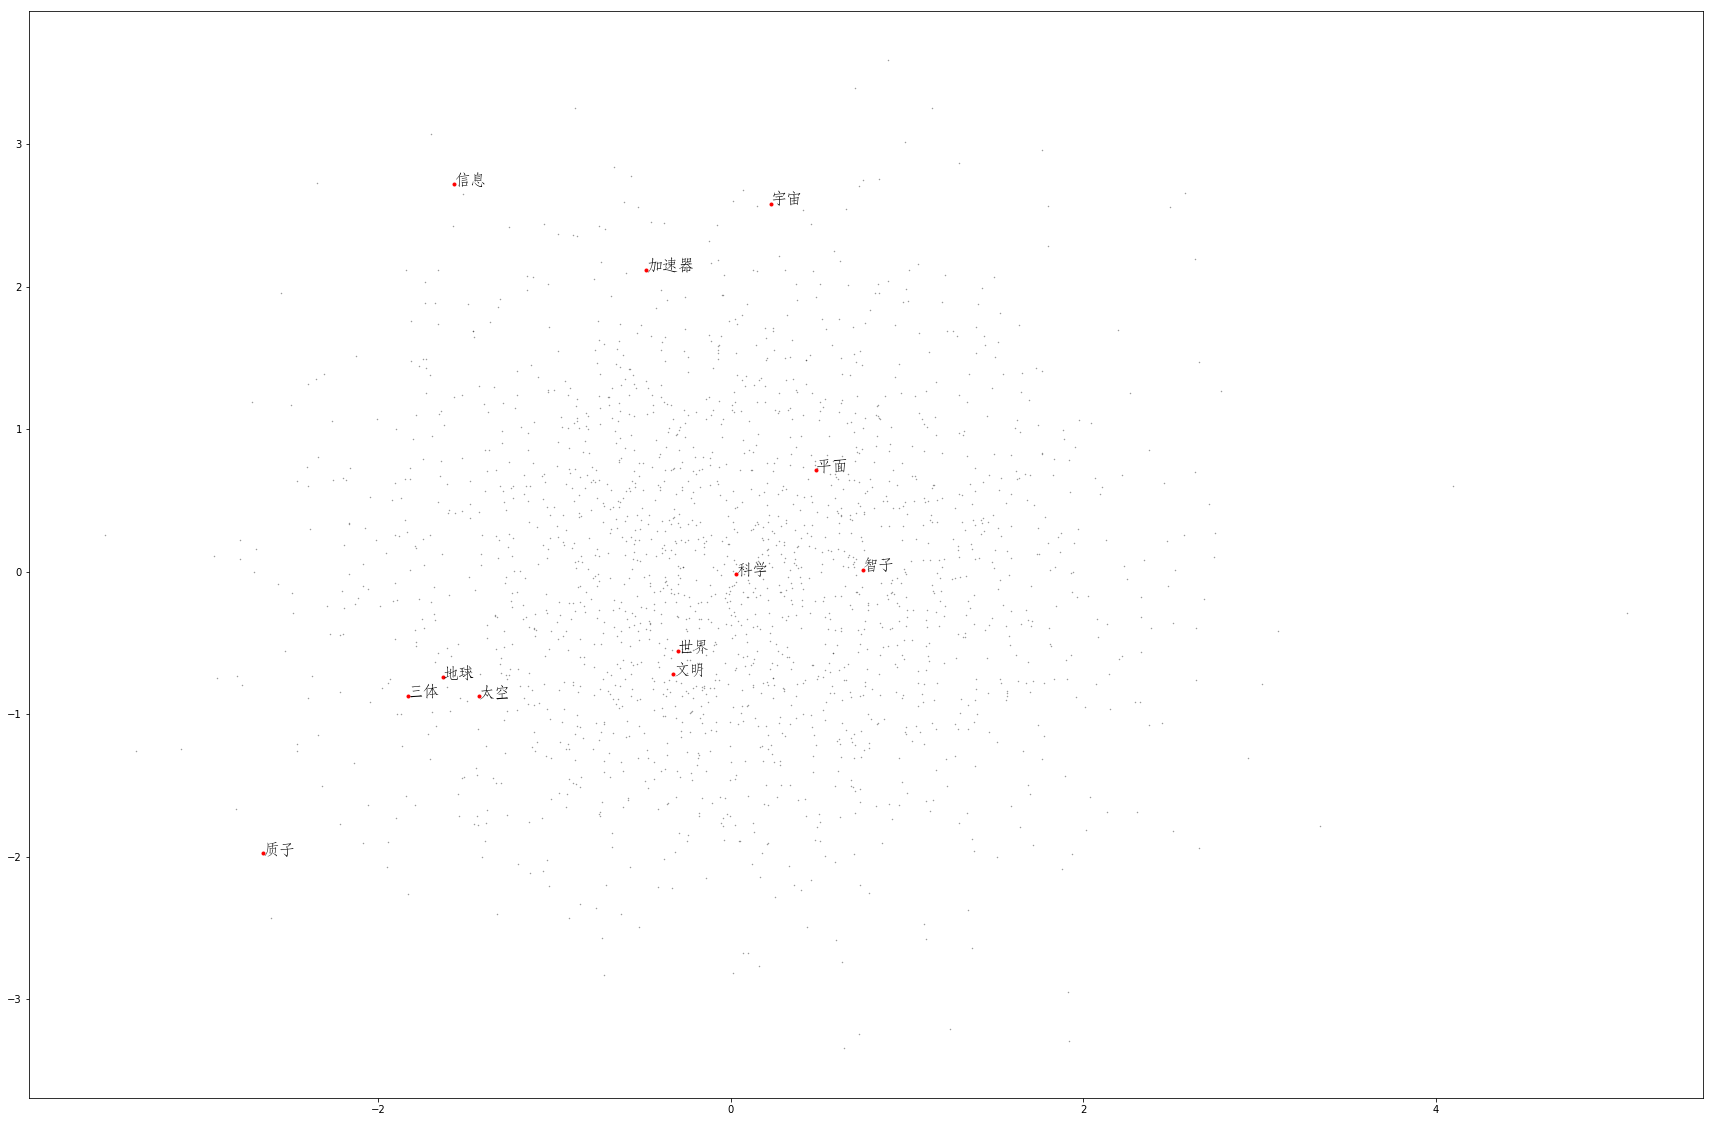

In [9]:
# 从训练好的模型中提取每个单词的向量
vec = model.extract(torch.tensor([v[0] for v in word_to_idx.values()], dtype = torch.long))
vec = vec.data.numpy()

# 利用PCA算法进行降维
X_reduced = PCA(n_components=2).fit_transform(vec)


# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.4, color = 'black')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '信息']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='../input/wordvector/华文仿宋.ttf', size=16)
for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'black')

#### 2). 临近词向量

In [10]:
# 定义计算cosine相似度的函数
def cos_similarity(vec1, vec2):
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    norm = norm1 * norm2
    dot = np.dot(vec1, vec2)
    result = dot / norm if norm > 0 else 0
    return result
    
# 在所有的词向量中寻找到与目标词（word）相近的向量，并按相似度进行排列
def find_most_similar(word, vectors, word_idx):
    vector = vectors[word_to_idx[word][0]]
    simi = [[cos_similarity(vector, vectors[num]), key] for num, key in enumerate(word_idx.keys())]
    sort = sorted(simi)[::-1]
    words = [i[1] for i in sort]
    return words

# 与智子靠近的词汇
find_most_similar('智子', vec, word_to_idx)

['智子',
 '惊奇',
 '承认',
 '这种',
 '镜像',
 '九维',
 '编制',
 '天光',
 '这里',
 '宣传',
 '因为',
 '消灭',
 '得到',
 '输入',
 '冷静下来',
 '几何',
 '所',
 '群星',
 '科学',
 '高能态',
 '推移',
 '连成',
 '散热片',
 '令',
 '六维',
 '地面',
 '广为流传',
 '刺中',
 '看',
 '高维',
 '核弹',
 '回到',
 '山脉',
 '利用',
 '染色',
 '几个',
 '低速',
 '同志',
 '这有',
 '再次',
 '南半球',
 '速度',
 '船坞',
 '那要',
 '这此',
 '停止',
 '观察者',
 '上来',
 '活动',
 '四百五十万',
 '汲取',
 '一大堆',
 '难以想象',
 '担心',
 '比',
 '附近',
 '会址',
 '汇集',
 '有人',
 '很慢',
 '辐条',
 '拍照',
 '光斑',
 '摆动',
 '讨厌',
 '开发',
 '映出',
 '照',
 '增长',
 '过',
 '巨大',
 '您',
 '不断',
 '不由',
 '术语',
 '串行',
 '生命',
 '光锥',
 '有害',
 '想到',
 '昏暗',
 '神迹',
 '以前',
 '任意',
 '下来',
 '一台',
 '大自然',
 '告诉',
 '就',
 '图片',
 '许多',
 '正常',
 '足够',
 '它',
 '众目睽睽',
 '地用',
 '接天',
 '夜',
 '骤然',
 '受',
 '尘柱',
 '舞蹈',
 '生物',
 '时光',
 '心理',
 '平面',
 '可能',
 '紧张',
 '现时',
 '热量',
 '照着',
 '群',
 '借',
 '微观粒子',
 '连续',
 '柔和',
 '交流',
 '呈',
 '还会',
 '不知',
 '猜测',
 '绝大多数',
 '问',
 '类似',
 '栩栩如生',
 '恒星',
 '真是',
 '歧途',
 '感光片',
 '占据',
 '降临',
 '十几万',
 '认为',
 '之一',
 '几何体',
 '捕捉',
 '电磁场',
 '无边',
 '镜面',
 '天顶',
 '除非',
 

## 二、Word2Vec

Word2Vec是Google推出的一个开源的词向量计算工具，它被内嵌到了gensim软件包里。
在本课程中，我们主要展示了自己调用Word2Vec训练词向量和读取已经训练好的词向量两种方法，并展示了如何利用词向量来进行一些简单的推理

### 1. 自己训练一个小语料

In [11]:
# 读入文件、分词，形成一句一句的语料
# 注意跟前面处理不一样的地方在于，我们一行一行地读入文件，从而自然利用行将文章分开成“句子”
f = open("../input/wordvector/三体.txt", 'r', encoding='utf-8')
lines = []
for line in f:
    temp = jieba.lcut(line)
    words = []
    for i in temp:
        #过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words) > 0:
        lines.append(words)
    

In [12]:
# 调用Word2Vec的算法进行训练。
# 参数分别为：size: 嵌入后的词向量维度；window: 上下文的宽度，min_count为考虑计算的单词的最低词频阈值
model = Word2Vec(lines, size = 20, window = 2 , min_count = 0)

In [13]:
model.wv.most_similar('智子', topn = 20)

[('更', 0.999717652797699),
 ('最', 0.999627947807312),
 ('存在', 0.9996269941329956),
 ('那些', 0.9996106028556824),
 ('潘寒', 0.9996054172515869),
 ('得', 0.9995920062065125),
 ('他们', 0.9995850920677185),
 ('为', 0.9995841979980469),
 ('被', 0.9995542764663696),
 ('显然', 0.9995490908622742),
 ('个', 0.9995473027229309),
 ('大', 0.9995462894439697),
 ('开始', 0.9995445013046265),
 ('多', 0.9995391964912415),
 ('研究', 0.9995349049568176),
 ('下', 0.9995313882827759),
 ('由', 0.9995259046554565),
 ('看看', 0.9995218515396118),
 ('计算机', 0.9995158314704895),
 ('这个', 0.9995145797729492)]

In [14]:
# 将词向量投影到二维空间
rawWordVec = []
word2ind = {}
for i, w in enumerate(model.wv.vocab):
    rawWordVec.append(model[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


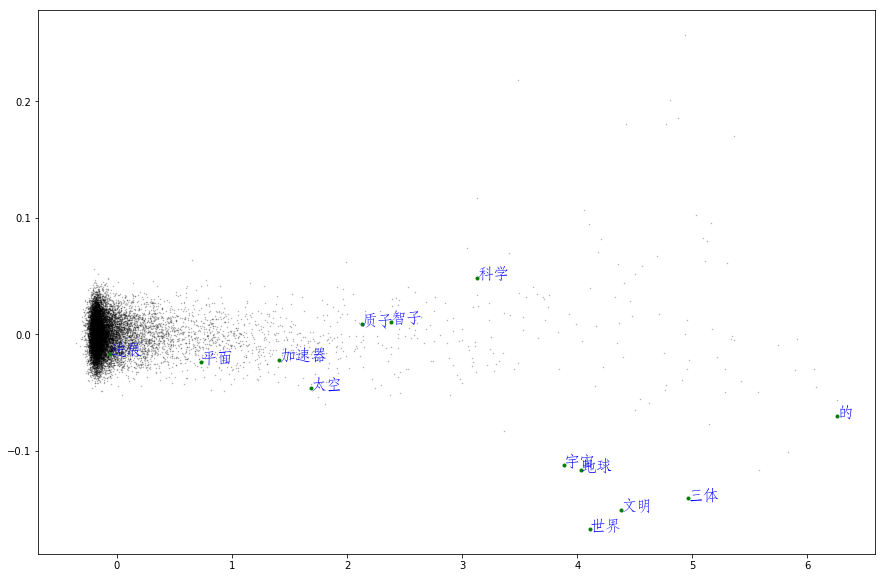

In [15]:
# 绘制星空图
# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.3, color = 'black')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '进展','的']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='../input/wordvector/华文仿宋.ttf', size=16)
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'green')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'blue')

### 2、调用一个现成的词向量

1). 大规模词向量可视化

该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量，
下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [16]:
# 加载词向量
word_vectors = KeyedVectors.load_word2vec_format('../input/chinese-word-vector/vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [17]:
# PCA降维
rawWordVec = []
word2ind = {}
for i, w in enumerate(word_vectors.vocab):
    rawWordVec.append(word_vectors[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [18]:
# 查看相似词
word_vectors.most_similar('物理', topn = 20)

[('化学', 0.7124662399291992),
 ('物理化学', 0.6906830072402954),
 ('物理学', 0.6732755303382874),
 ('力学', 0.6633583307266235),
 ('数学', 0.6431227326393127),
 ('电学', 0.6256974935531616),
 ('原理', 0.6226458549499512),
 ('生物学', 0.6126975417137146),
 ('数学物理', 0.6115936040878296),
 ('电化学', 0.6058178544044495),
 ('非线性', 0.595616340637207),
 ('量子力学', 0.5924554467201233),
 ('热学', 0.5853999853134155),
 ('电磁场', 0.5820313096046448),
 ('物理现象', 0.5818398594856262),
 ('凝聚态', 0.5746456384658813),
 ('计算机', 0.5690045356750488),
 ('流体力学', 0.5671141147613525),
 ('化学性', 0.563992440700531),
 ('微积分', 0.5628953576087952)]

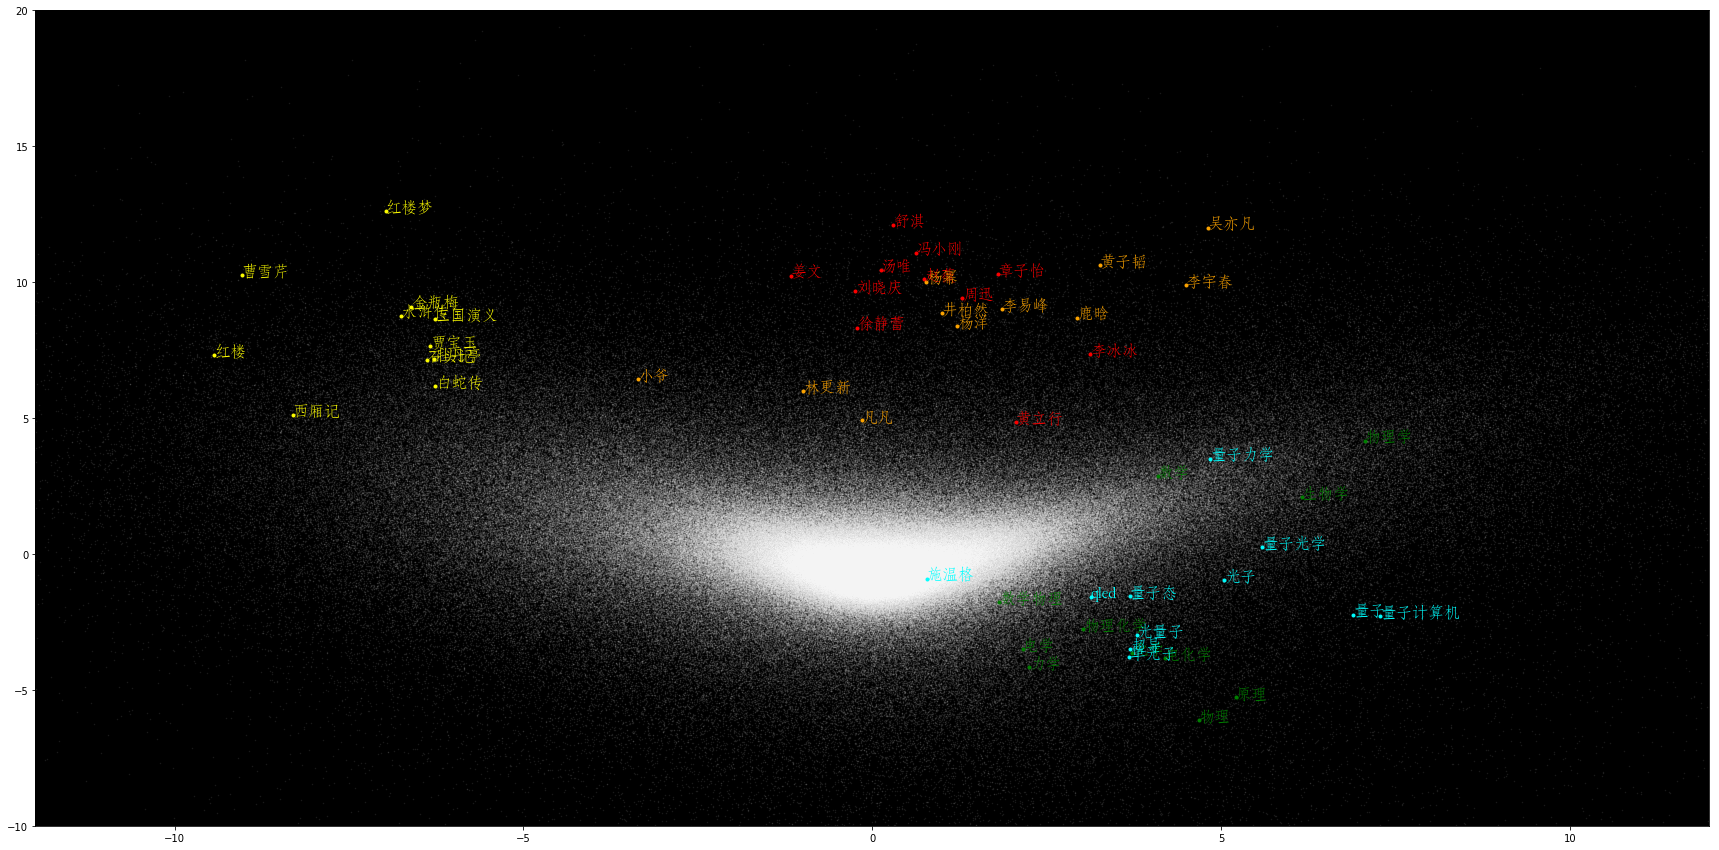

In [19]:
# 绘制星空图
# 绘制所有的词汇
fig = plt.figure(figsize = (30, 15))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.1, color = 'white')

ax.set_xlim([-12,12])
ax.set_ylim([-10,20])


# 选择几个特殊词汇，不仅画它们的位置，而且把它们的临近词也画出来
words = {'徐静蕾','吴亦凡','物理','红楼梦','量子'}
all_words = []
for w in words:
    lst = word_vectors.most_similar(w)
    wds = [i[0] for i in lst] # 词
    metrics = [i[1] for i in lst] # 相似度
    wds = np.append(wds, w)
    all_words.append(wds)


zhfont1 = matplotlib.font_manager.FontProperties(fname='../input/wordvector/华文仿宋.ttf', size=16)
colors = ['red', 'yellow', 'orange', 'green', 'cyan', 'cyan']
for num, wds in enumerate(all_words):
    for w in wds:
        if w in word2ind:
            ind = word2ind[w] # 获取index
            xy = X_reduced[ind] # 获取每个word的二维坐标
            plt.plot(xy[0], xy[1], '.', alpha =1, color = colors[num])
            plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = colors[num])
plt.savefig('88.png',dpi =600)

#### 2). 类比关系实验

In [20]:
# 女人－男人＝？－国王
words = word_vectors.most_similar(positive=['女人', '国王'], negative=['男人'])
words

[('王后', 0.6745086312294006),
 ('国王队', 0.6190646886825562),
 ('爵士', 0.6134730577468872),
 ('路易十四', 0.6120332479476929),
 ('萨克拉门托', 0.6105179786682129),
 ('莱恩', 0.609720766544342),
 ('教皇', 0.6067279577255249),
 ('乔治', 0.6061576008796692),
 ('拿破仑', 0.596650242805481),
 ('路易十五', 0.5955969095230103)]

In [21]:
# 北京－中国＝？－俄罗斯
words = word_vectors.most_similar(positive=['北京', '俄罗斯'], negative=['中国'])
words

[('莫斯科', 0.6559879779815674),
 ('明斯克', 0.5312925577163696),
 ('基辅', 0.5114986896514893),
 ('伊尔库茨克', 0.510644793510437),
 ('安卡拉', 0.503899872303009),
 ('哈萨克斯坦', 0.5037742257118225),
 ('白俄罗斯', 0.49618425965309143),
 ('新西伯利亚', 0.49343931674957275),
 ('圣彼得堡', 0.49158066511154175),
 ('加里宁格勒', 0.48882216215133667)]

In [22]:
# 自然科学－物理学＝？－政治学
words = word_vectors.most_similar(positive=['自然科学', '政治学'], negative=['物理学'])
words

[('人文科学', 0.6870070099830627),
 ('社科', 0.6561877727508545),
 ('历史学', 0.6510788202285767),
 ('社会学', 0.6255476474761963),
 ('法学', 0.6240648031234741),
 ('人文学科', 0.6205806136131287),
 ('外交学', 0.6159368753433228),
 ('社会科学', 0.6153010725975037),
 ('人类学', 0.6027011871337891),
 ('社科类', 0.6017463207244873)]

In [23]:
# 王菲－章子怡＝？－汪峰
words = word_vectors.most_similar(positive=['王菲', '汪峰'], negative=['章子怡'])
words

[('窦唯', 0.7128487825393677),
 ('窦靖童', 0.6921027302742004),
 ('张韶涵', 0.6702383160591125),
 ('齐秦', 0.6421184539794922),
 ('谢霆锋', 0.6239088177680969),
 ('那英', 0.6225878596305847),
 ('哈林', 0.6223201751708984),
 ('李亚鹏', 0.6200002431869507),
 ('张惠妹', 0.615531325340271),
 ('李宗盛', 0.6131705045700073)]

In [24]:
# 尽可能多地选出所有的货币
words = word_vectors.most_similar(positive=['美元', '英镑'], topn = 100)
words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], topn = 100)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], negative = ['原油价格', '7800万'], topn = 100)
words

[('欧元', 0.8743425607681274),
 ('澳元', 0.8102496862411499),
 ('日圆', 0.7611238956451416),
 ('加元', 0.7465021014213562),
 ('人民币', 0.7449039816856384),
 ('美金', 0.7149821519851685),
 ('韩元', 0.7145756483078003),
 ('瑞郎', 0.7067820429801941),
 ('英磅', 0.6967371702194214),
 ('卢布', 0.6947215795516968),
 ('卢比', 0.6720969080924988),
 ('镑', 0.6703317761421204),
 ('比索', 0.6515073776245117),
 ('港元', 0.6429407000541687),
 ('马币', 0.6186234951019287),
 ('挪威克朗', 0.6135693788528442),
 ('雷亚尔', 0.6096118092536926),
 ('丹麦克朗', 0.6067554354667664),
 ('美圆', 0.6023485660552979),
 ('美元汇率', 0.6011217832565308),
 ('令吉', 0.5950231552124023),
 ('印尼盾', 0.5935584306716919),
 ('里亚尔', 0.5928155183792114),
 ('新台币', 0.5848963260650635),
 ('澳币', 0.5745424032211304),
 ('欧元也', 0.5737853646278381),
 ('印度卢比', 0.5609548091888428),
 ('金价', 0.5518711805343628),
 ('法郎', 0.5517901182174683),
 ('瑞典克朗', 0.5478922128677368),
 ('韩圆', 0.5478326678276062),
 ('台币', 0.5418106913566589),
 ('黄金价格', 0.5329560041427612),
 ('创纪录', 0.530708372592926

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码